In [ ]:
!pip install feature-engine
!pip install textstat
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2

In [ ]:
import warnings
import textstat
import pandas as pd
import nltk
from transformers import pipeline
import spacy
from nltk.tokenize import sent_tokenize
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re
import spacy
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from feature_engine.selection import DropCorrelatedFeatures, RecursiveFeatureElimination
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.impute import SimpleImputer

In [ ]:
!unzip /content/thietcrow.csv.zip
!unzip /content/train.csv.zip


Archive:  /content/thietcrow.csv.zip
  inflating: thietcrow.csv           
  inflating: __MACOSX/._thietcrow.csv  
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
thietcrowds = pd.read_csv('/content/thietcrow.csv')
train = pl.read_csv('/content/train.csv', truncate_ragged_lines=True, encoding='utf-8')
sample = train.head(30)

In [ ]:
class FeatureExtraction():

      def removeHTML(self, text):
          clean = re.compile('<.*?>')
          return re.sub(clean, '', text)

      def dataPreprocessing(self, x):
          x = x.lower()
          x = self.removeHTML(x)
          x = re.sub("@\w+", '', x)
          x = re.sub("'\d+", '', x)
          x = re.sub("\d+", '', x)
          x = re.sub("http\w+", '', x)
          x = re.sub(r"\s+", " ", x)
          x = re.sub(r"\.+", ".", x)
          x = re.sub(r"\,+", ",", x)
          x = x.strip()
          return x

      def __init__(self, df):
          self.df = df.select(['essay_id', 'full_text'])
          self.full_text_clean = self.df.with_columns(pl.col("full_text").map_elements(self.dataPreprocessing).alias("full_text_clean"))

          self.paragraphs_df = self.df.with_columns(
              pl.col('full_text').str.split(by="\n\n").alias("paragraphs")
          )
          self.paragraphs_df = self.paragraphs_df.explode("paragraphs").select(['essay_id', 'paragraphs'])
          self.paragraphs = self.paragraphs_df.with_columns(
              pl.col('paragraphs').map_elements(self.dataPreprocessing).alias("paragraph")
          ).select(['essay_id', 'paragraph'])
          self.sentences_df = self.paragraphs.with_columns(
              pl.col('paragraph').str.split(by=". ").alias("sentences")
          )
          self.sentences = self.sentences_df.explode("sentences").select(['essay_id', 'sentences'])
          self.words_df = self.paragraphs.with_columns(pl.col('paragraph').str.split(by=" ").alias("word"))
          self.words = self.words_df.explode("word").select(['essay_id', 'word'])
          # self.paragraphs stores the exploded paragraphs with essay_id
          # self.sentences stores the exploded sentences with essay_id
          # self.words stores the exploded words with essay_id
          self.sentence_fea = ['sentence_len', 'sentence_word_cnt']
          self.paragraph_fea = ['paragraph_len', 'paragraph_sentence_cnt', 'paragraph_word_cnt']
          self.vectorizer = TfidfVectorizer(
                                              tokenizer=word_tokenize,
                                              preprocessor=self.dataPreprocessing,
                                              strip_accents='unicode',
                                              analyzer='word',
                                              ngram_range=(2, 3),
                                              min_df=0.05,
                                              max_df=0.9,
                                              sublinear_tf=True
                                              )
          self.nlp = spacy.load('en_core_web_sm')

      def Paragraph_Preprocess(self):
          paragraphs_clean = self.paragraphs.with_columns(pl.col('paragraph').map_elements(self.dataPreprocessing))
          paragraphs_clean = paragraphs_clean.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
          paragraphs_clean = paragraphs_clean.with_columns((pl.col('paragraph_len') >= 25).alias("valid_paragraph"))
          paragraphs_clean = paragraphs_clean.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split("."))).alias("paragraph_sentence_cnt"),
                                                          pl.col('paragraph').map_elements(lambda x: len(x.split(" "))).alias("paragraph_word_cnt"))
          return paragraphs_clean

      def Paragraph_Eng(self, paragraphs_clean):
          aggs = [
              *[pl.col('valid_paragraph').filter(pl.col('paragraph_len') >= i)
              .count().alias(f'paragraph_{i}_cnt') for i in [25, 100, 200, 300, 400, 500, 600, 700]],
              *[pl.col(fea).filter(pl.col('valid_paragraph')).max().alias(f"{fea}_max") for fea in self.paragraph_fea],
              *[pl.col(fea).filter(pl.col('valid_paragraph')).mean().alias(f"{fea}_mean") for fea in self.paragraph_fea],
              *[pl.col(fea).filter(pl.col('valid_paragraph')).min().alias(f"{fea}_min") for fea in self.paragraph_fea],
              *[pl.col(fea).filter(pl.col('valid_paragraph')).first().alias(f"{fea}_first") for fea in self.paragraph_fea],
              *[pl.col(fea).filter(pl.col('valid_paragraph')).last().alias(f"{fea}_last") for fea in self.paragraph_fea],
          ]
          paragraphs_features = paragraphs_clean.group_by("essay_id", maintain_order=True).agg(aggs).sort("essay_id")
          return paragraphs_features

      def Sentence_Preprocess(self):
          sentences_clean = self.sentences.with_columns(pl.col('sentences').map_elements(lambda x: len(x)).alias("sentence_len"))
          sentences_clean = sentences_clean.with_columns((pl.col('sentence_len') >= 15).alias("valid_sentences"))
          sentences_clean = sentences_clean.with_columns(pl.col('sentences').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
          return sentences_clean

      def Sentence_Eng(self, sentences_clean):
          aggs = [
              *[pl.col('valid_sentences').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15, 50, 100, 150, 200, 250, 300]],
              *[pl.col(fea).filter(pl.col('valid_sentences')).max().alias(f"{fea}_max") for fea in self.sentence_fea],
              *[pl.col(fea).filter(pl.col('valid_sentences')).mean().alias(f"{fea}_mean") for fea in self.sentence_fea],
              *[pl.col(fea).filter(pl.col('valid_sentences')).min().alias(f"{fea}_min") for fea in self.sentence_fea],
              *[pl.col(fea).filter(pl.col('valid_sentences')).first().alias(f"{fea}_first") for fea in self.sentence_fea],
              *[pl.col(fea).filter(pl.col('valid_sentences')).last().alias(f"{fea}_last") for fea in self.sentence_fea],
          ]
          sentences_features = sentences_clean.group_by("essay_id", maintain_order=True).agg(aggs).sort("essay_id")
          return sentences_features

      def Word_Preprocess(self):
          words_clean = self.words.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
          words_clean = words_clean.with_columns((pl.col('word_len') != 0).alias("valid_word"))
          return words_clean

      def Word_Eng(self, words_clean):
          aggs = [
              *[pl.col('valid_word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15)],
              pl.col('word_len').filter(pl.col('valid_word')).max().alias(f"word_len_max"),
              pl.col('word_len').filter(pl.col('valid_word')).mean().alias(f"word_len_mean"),
              pl.col('word_len').filter(pl.col('valid_word')).std().alias(f"word_len_std"),
              pl.col('word_len').filter(pl.col('valid_word')).quantile(0.25).alias(f"word_len_q1"),
              pl.col('word_len').filter(pl.col('valid_word')).quantile(0.50).alias(f"word_len_q2"),
              pl.col('word_len').filter(pl.col('valid_word')).quantile(0.75).alias(f"word_len_q3"),
          ]
          words_features = words_clean.group_by("essay_id", maintain_order=True).agg(aggs).sort("essay_id")
          return words_features

      def get_readability_features(self):
          readability_metrics = [
              ("fk_score", lambda txt: textstat.flesch_kincaid_grade(txt)),
              ("gf_score", lambda txt: textstat.gunning_fog(txt)),
              ("cl_score", lambda txt: textstat.coleman_liau_index(txt)),
              ("ar_score", lambda txt: textstat.automated_readability_index(txt)),
              ("fr_score", lambda txt: textstat.flesch_reading_ease(txt)),
              ("lw_score", lambda txt: textstat.linsear_write_formula(txt)),
              ("si_score", lambda txt: textstat.smog_index(txt)),
              ("dc_score", lambda txt: textstat.dale_chall_readability_score(txt)),
              ("dw_score", lambda txt: textstat.difficult_words(txt)),
              ("fh_score", lambda txt: textstat.fernandez_huerta(txt)),
              ("sp_score", lambda txt: textstat.szigriszt_pazos(txt)),
              ("gp_score", lambda txt: textstat.gutierrez_polini(txt)),
              ("cr_score", lambda txt: textstat.crawford(txt)),
              ("gi_score", lambda txt: textstat.gulpease_index(txt)),
              ("os_score", lambda txt: textstat.osman(txt)),
          ]
          readability_features = self.full_text_clean
          for col_name, func in readability_metrics:
              readability_features = readability_features.with_columns(pl.col("full_text_clean").map_elements(func).alias(col_name))
          readability_features = readability_features.drop(['full_text','full_text_clean'])
          return readability_features
      def pos_tag_frequency(self, text):
          doc = self.nlp(text)
          pos_counts = Counter([token.pos_ for token in doc])
          punctuation_marks = [".", ",", "!", "?"]
          for mark in punctuation_marks:
              pos_counts[mark] = text.count(mark)
          return pos_counts

      def add_pos_frequencies(self,null_threshold=0.3):
          pos_frequencies = self.full_text_clean.with_columns([
              pl.col("full_text_clean").map_elements(lambda text: self.pos_tag_frequency(text)).alias("pos_frequencies")
          ])
          pos_tags = set(tag for counts in pos_frequencies["pos_frequencies"] for tag in counts)
          for tag in pos_tags:
              pos_frequencies = pos_frequencies.with_columns(pl.col("pos_frequencies").map_elements(lambda freqs: freqs.get(tag, 0)).alias(f"pos_{tag}"))
          pos_frequencies = pos_frequencies.drop("pos_frequencies")
          null_threshold_count = int(null_threshold * pos_frequencies.shape[0])
          cols_to_drop = []
          for tag in pos_tags:
              pos_col = f"pos_{tag}"
              null_count = pos_frequencies[pos_col].is_null().sum()
              if null_count > null_threshold_count:
                  cols_to_drop.append(pos_col)

          if cols_to_drop:
              pos_frequencies = pos_frequencies.drop(cols_to_drop)
          pos_frequencies = pos_frequencies.drop('full_text','full_text_clean')
          return pos_frequencies


      def analyze_sentiment(self):
          sentiment_df = self.sentences.with_columns([
              pl.col("sentences").map_elements(lambda s: TextBlob(s).sentiment.polarity).alias("polarity"),
              pl.col("sentences").map_elements(lambda s: TextBlob(s).sentiment.subjectivity).alias("subjectivity")
          ])
          sentiment_df = sentiment_df.group_by("essay_id").agg([
              pl.col("polarity").mean().alias("average_polarity"),
              pl.col("subjectivity").mean().alias("average_subjectivity")
          ])
          return sentiment_df
      def lexical_diversity_features(self):
          def ttr(text):
              tokens = text.split()
              if len(tokens) == 0:
                return 0
              return len(set(tokens)) / len(tokens)

          def hapax_legomena(text):
              tokens = text.split()
              freq = Counter(tokens)
              return sum(1 for count in freq.values() if count == 1)

          def hapax_dislegomena(text):
              tokens = text.split()
              freq = Counter(tokens)
              return sum(1 for count in freq.values() if count == 2)

          result = self.sentences.with_columns([
              pl.col("sentences").map_elements(ttr).alias("ttr"),
              pl.col("sentences").map_elements(hapax_legomena).alias("hapax_legomena"),
              pl.col("sentences").map_elements(hapax_dislegomena).alias("hapax_dislegomena")
          ]).group_by("essay_id").agg([
              pl.col("ttr").mean().alias("average_ttr"),
              pl.col("hapax_legomena").mean().alias("average_hapax_legomena"),
              pl.col("hapax_dislegomena").mean().alias("average_hapax_dislegomena")
          ])
          result.drop('sentences')
          return result
      def calculate_pos_ngrams(self, text, n):
          doc = self.nlp(text)
          pos_tags = [token.pos_ for token in doc]
          ngrams = zip(*[pos_tags[i:] for i in range(n)])
          return ["_".join(ngram) for ngram in ngrams]

      def add_pos_ngram_features(self):
          ngram = self.sentences.with_columns([
              pl.col("sentences").map_elements(lambda text: len(self.calculate_pos_ngrams(text, 2))).alias("bigram"),
              pl.col("sentences").map_elements(lambda text: len(self.calculate_pos_ngrams(text, 3))).alias("trigram"),
          ]).group_by("essay_id").agg([
              pl.col("bigram").sum().alias("bigram_sum"),
              pl.col("trigram").sum().alias("trigram_sum"),
          ])
          return ngram

      def add_tfidf_features(self):
          texts = self.full_text_clean.get_column("full_text_clean").to_list()
          tfidf_matrix = self.vectorizer.fit_transform(texts)
          feature_names = self.vectorizer.get_feature_names_out()
          tfidf_df = pl.DataFrame(tfidf_matrix.toarray())
          tfidf = self.full_text_clean.hstack(tfidf_df)
          tfidf = tfidf.drop('full_text','full_text_clean')
          return tfidf
      def result(self):
          paragraphs_clean = self.Paragraph_Preprocess()
          paragraphs_features = self.Paragraph_Eng(paragraphs_clean)
          sentences_clean = self.Sentence_Preprocess()
          sentences_features = self.Sentence_Eng(sentences_clean)
          words_clean = self.Word_Preprocess()
          words_features = self.Word_Eng(words_clean)
          readability_features = self.get_readability_features()
          pos_frequencies = self.add_pos_frequencies()
          sentiment_analysis = self.analyze_sentiment()
          lexical_diversity_features = self.lexical_diversity_features()
          ngram = self.add_pos_ngram_features()
          tfidf = self.add_tfidf_features()
          result = words_features.join(sentences_features, on='essay_id')
          result = result.join(paragraphs_features, on='essay_id')
          result = result.join(readability_features, on='essay_id')
          result = result.join(pos_frequencies, on='essay_id')
          result = result.join(sentiment_analysis, on='essay_id')
          result = result.join(lexical_diversity_features, on='essay_id')
          result = result.join(ngram, on='essay_id')
          result = result.join(tfidf, on='essay_id')


          return result.to_pandas()


In [ ]:
FE5 = FeatureExtraction(sample)
processsed_feats = FE5.result()


In [ ]:
processsed_feats = pd.merge(thietcrowds, processsed_feats, on ='essay_id', how = 'inner')

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection, DropConstantFeatures, DropDuplicateFeatures, SelectBySingleFeaturePerformance
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from feature_engine.imputation import ArbitraryNumberImputer

In [ ]:
X_train = processsed_feats.drop(['full_text','grammar','score','essay_id'],axis=1)
y_train = processsed_feats['score']

In [ ]:
pipe = Pipeline([
    ('imputer', ArbitraryNumberImputer(arbitrary_number=0)),
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlation', SmartCorrelatedSelection(
        threshold=0.8,
        selection_method="model_performance",
        estimator=RandomForestClassifier(n_estimators=10, random_state=1),
    )),
])
pipe.fit(X_train, y_train)
X_train = pipe.tramsform(X_train, y_train)

Pipeline(steps=[('imputer', ArbitraryNumberImputer(arbitrary_number=0)),
                ('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                                           random_state=1),
                                          selection_method='model_performance'))])

In [ ]:
def qwk(y_true, y_pred, **kwargs):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer = make_scorer(qwk)
cv = StratifiedKFold(n_splits=3)

In [ ]:

rf_sel = SelectBySingleFeaturePerformance(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1),
    scoring=qwk_scorer,
    cv=cv,
    threshold=None,
)

In [ ]:
lasso_model = linear_model.Lasso(alpha=0.00001)
lasso_model.fit(X_train, y_train)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)

In [ ]:
rf_sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                                 estimator=RandomForestClassifier(max_depth=2,
                                                                  n_estimators=10,
                                                                  random_state=1),
                                 scoring=make_scorer(qwk, response_method='predict'))

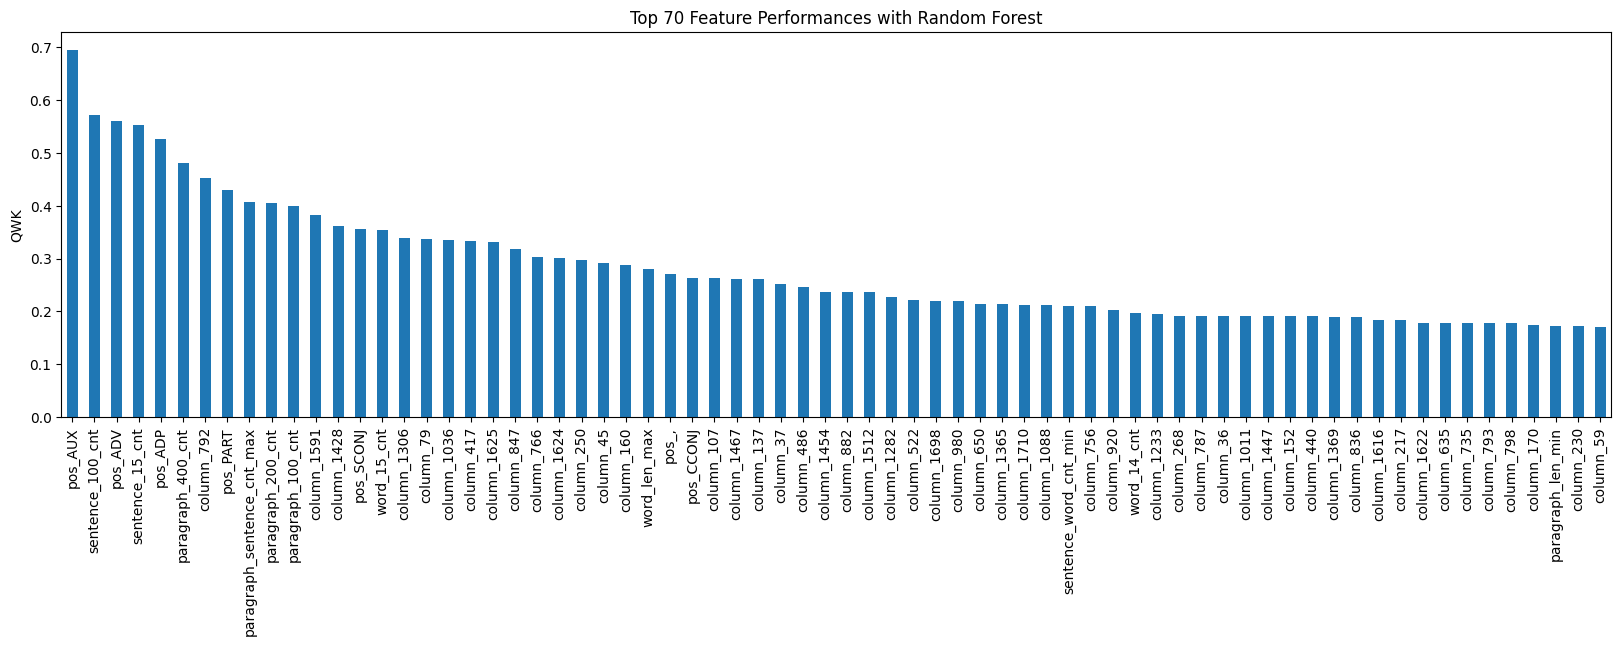

In [ ]:
rf_feature_performance_df = pd.Series(rf_sel.feature_performance_).sort_values(ascending=False).head(70)
rf_feature_performance_df.plot(kind='bar', figsize=(20, 5))
plt.ylabel('QWK')
plt.title('Top 70 Feature Performances with Random Forest')
plt.show()

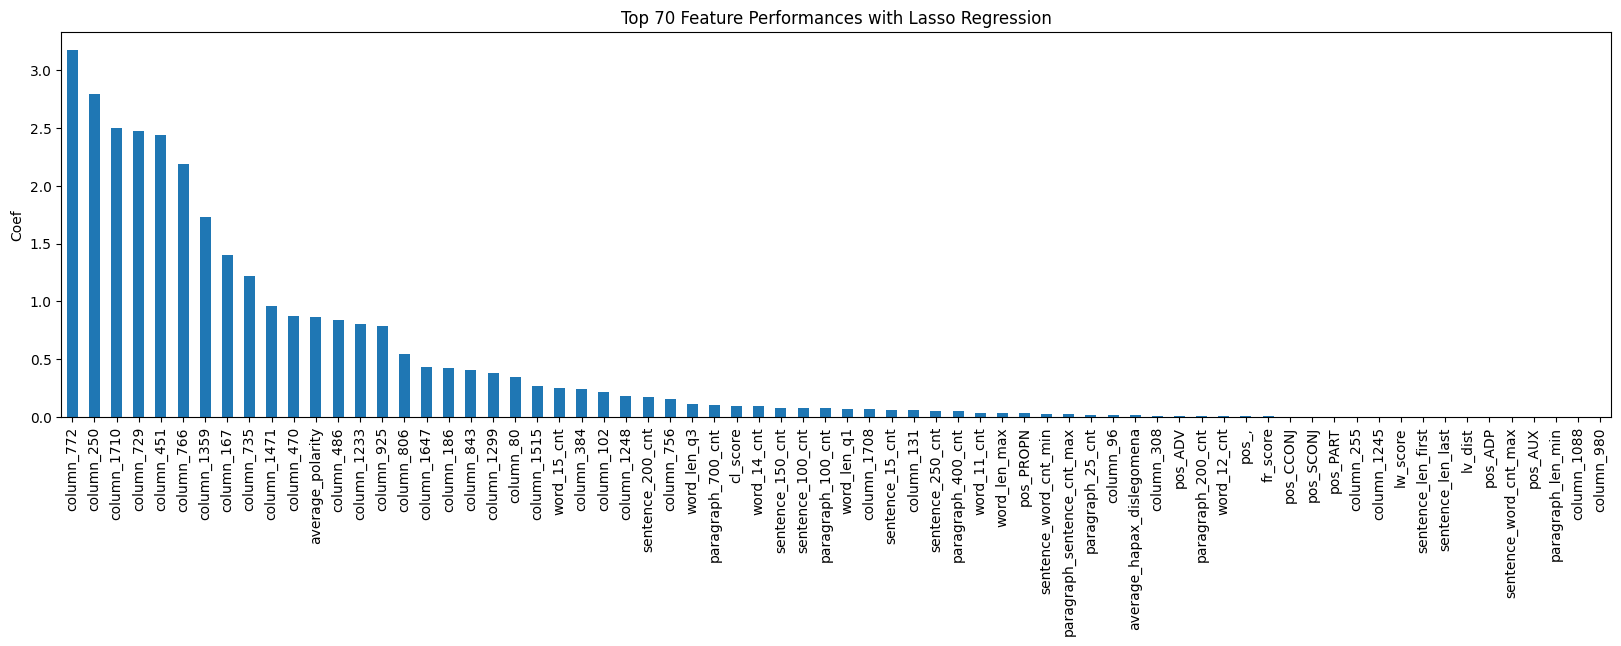

In [ ]:
lasso_feature_performance_df = lasso_coefs.abs().sort_values(ascending=False).head(70)
lasso_feature_performance_df.plot(kind='bar', figsize=(20, 5))
plt.ylabel('Coef')
plt.title('Top 70 Feature Performances with Lasso Regression')
plt.show()

In [ ]:
rf_sel.n_features_in_

525

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train)
pca_components = pd.DataFrame(pca.components_, columns=X_train.columns)

<Figure size 1000x600 with 0 Axes>

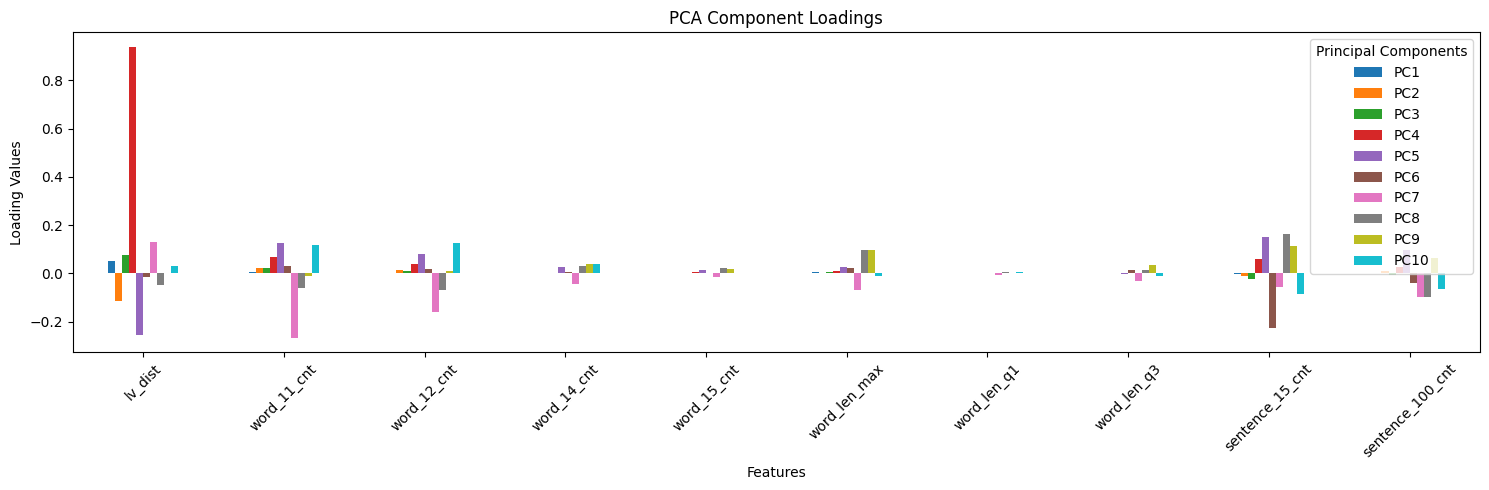

In [ ]:
plt.figure(figsize=(10, 6))
components = pca_components.T.head(10)
components.columns = [f'PC{i+1}' for i in range(components.shape[1])]
components.plot(kind='bar', figsize=(15, 5))

plt.title('PCA Component Loadings')
plt.xlabel('Features')
plt.ylabel('Loading Values')
plt.xticks(rotation=45)
plt.legend(title='Principal Components')
plt.tight_layout()
plt.show()

In [ ]:
pca_components_df = pd.DataFrame(pca.components_, columns=X_train.columns)
# Sort by the first principal component (assuming it's the most important)
pca_components_df.sort_values(by=pca_components_df.columns[0], ascending=False).to_csv('pca_components.csv', index=False)

# Save RF feature importance
rf_feature_importance_df = pd.Series(rf_sel.feature_performance_).sort_values(ascending=False)
rf_feature_importance_df.to_csv('rf_feature_importance.csv', index=True)

# Save Lasso feature importance
lasso_feature_importance_df = lasso_coefs.abs().sort_values(ascending=False)
lasso_feature_importance_df.to_csv('lasso_feature_importance.csv', index=True)

